# H1N1 Vaccination Rates

In this notebook, we will be creating models in order to predict whether or not a person would receive an H1N1 vaccine.  This data is being prepared for a company that distributes vaccines.  They are hoping to use this information to predict the number of vaccines they will need for a certain population. Our goal is to build a model with the highest possible accuracy for the test data set without overfitting to the training data set.

# Import Necessary Libraries and Data

In [9]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.ticker as mtick
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the Data
training_labels = pd.read_csv('Data/training_set_labels.csv', 
                              index_col='respondent_id')
training_features = pd.read_csv('Data/training_set_features.csv', 
                                index_col='respondent_id')

# Explore the Data

In [3]:
training_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


In [4]:
# Check H1N1 labels
training_labels.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

** Note this class imbalance for later. **

In [5]:
# Explore the training features
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [6]:
# Create one DataFrame to house all of our data
data_df = pd.concat([training_features, training_labels], axis=1)

In [7]:
data_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


# Clean the Data

## Remove Unnecessary Columns

The columns that we are removing either have to do with the Seasonal Vaccine, or have too much missing data.

In [8]:
# Drop unnecessary columns
h1n1_df = data_df.drop(['health_insurance',
                              'opinion_seas_vacc_effective',
                              'opinion_seas_risk',
                              'opinion_seas_sick_from_vacc',
                              'doctor_recc_seasonal',
                              'employment_industry',
                              'employment_occupation',
                              'seasonal_vaccine'], axis=1)
h1n1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  chronic_med_condition        25736 non-null  float64
 11  child_under_6_months         25887 non-null  float64
 12  health_worker                25903 non-null  float64
 13  opinion_h1n1_vac

## Dealing with Missing Data

In [9]:
# Check for missing data
print('Missing Data: \n',h1n1_df.isna().sum())

Missing Data: 
 h1n1_concern                     92
h1n1_knowledge                  116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_h1n1               2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
opinion_h1n1_sick_from_vacc     395
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                    2042
employment_status              1463
hhs_geo_region                    0
census_msa                        0
household_adults                249
household_ch

We will want to create a new value for columns missing between 5 and 10 percent of the data.  If the column is missing less than 5 percent of data values, we will drop those values.

In [10]:
print('5% of data:', round(26707*.05, 2))
print('10% of data:', round(26707*.1, 2))

5% of data: 1335.35
10% of data: 2670.7


Create a new category "unknown" for the columns with 1000+ missing entries.
Drop rows if the column is missing less than 1000 entries.
Columns to adjust: doctor_recc_h1n1, education, income_poverty, marital_status, rent_or_own, employment_status.

In [11]:
# Changing docter recc to an object dtype and filling NaN values
h1n1_df['doctor_recc_h1n1'].fillna(value='unknown', inplace=True)
h1n1_df['doctor_recc_h1n1'].replace(to_replace=0.0, value='No', inplace=True)
h1n1_df['doctor_recc_h1n1'].replace(to_replace=1.0, value='Yes', inplace=True)

In [12]:
# Create an unknown category for missing data
need_new_category = ['education', 
                     'income_poverty', 
                     'marital_status', 
                     'rent_or_own', 
                     'employment_status']
for column in need_new_category:
    h1n1_df[column].fillna(value='unknown', inplace=True)

In [13]:
# Check our remaining null values
h1n1_df.isna().sum()

h1n1_concern                    92
h1n1_knowledge                 116
behavioral_antiviral_meds       71
behavioral_avoidance           208
behavioral_face_mask            19
behavioral_wash_hands           42
behavioral_large_gatherings     87
behavioral_outside_home         82
behavioral_touch_face          128
doctor_recc_h1n1                 0
chronic_med_condition          971
child_under_6_months           820
health_worker                  804
opinion_h1n1_vacc_effective    391
opinion_h1n1_risk              388
opinion_h1n1_sick_from_vacc    395
age_group                        0
education                        0
race                             0
sex                              0
income_poverty                   0
marital_status                   0
rent_or_own                      0
employment_status                0
hhs_geo_region                   0
census_msa                       0
household_adults               249
household_children             249
h1n1_vaccine        

In [14]:
# Drop the remaining null values from the dataset
h1n1_df.dropna(inplace=True)
h1n1_df.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa                     0
household_adults               0
household_children             0
h1n1_vaccine                   0
dtype: int64

## Split our Data

Now that we have taken care of our null values, we can split our data into features and labels for our train test split.

In [15]:
# Create features and labels
h1n1_features = h1n1_df.drop('h1n1_vaccine', axis=1)
h1n1_labels = h1n1_df['h1n1_vaccine']

In [16]:
# Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(h1n1_features,
                                                   h1n1_labels,
                                                   test_size=.25,
                                                   random_state=42)

## Encoding Categorical Columns

Before we can use this data to create models, we need all of our data values to be numeric.  We will use a OneHotEncoder to achieve this.

In [17]:
# Check for categorical columns
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18621 entries, 18434 to 25446
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 18621 non-null  float64
 1   h1n1_knowledge               18621 non-null  float64
 2   behavioral_antiviral_meds    18621 non-null  float64
 3   behavioral_avoidance         18621 non-null  float64
 4   behavioral_face_mask         18621 non-null  float64
 5   behavioral_wash_hands        18621 non-null  float64
 6   behavioral_large_gatherings  18621 non-null  float64
 7   behavioral_outside_home      18621 non-null  float64
 8   behavioral_touch_face        18621 non-null  float64
 9   doctor_recc_h1n1             18621 non-null  object 
 10  chronic_med_condition        18621 non-null  float64
 11  child_under_6_months         18621 non-null  float64
 12  health_worker                18621 non-null  float64
 13  opinion_h1n1

In [18]:
# Create a list of categoricals
categoricals = ['age_group',
               'education',
               'sex',
               'income_poverty',
               'marital_status',
               'rent_or_own',
               'employment_status',
               'hhs_geo_region',
               'census_msa',
               'race',
               'doctor_recc_h1n1']

In [19]:
# Use One Hot Encode to transform categorical columns
ohe = OneHotEncoder()
ohe.fit(X_train[categoricals])
X_train_ohe = ohe.transform(X_train[categoricals]).toarray()
X_train_ohe_df = pd.DataFrame(X_train_ohe, 
                              columns = ohe.get_feature_names(categoricals), 
                              index = X_train.index)

In [20]:
# Create a new dataframe
X_train_numerical = X_train.drop(categoricals, axis=1)
X_train_final = pd.concat([X_train_ohe_df, X_train_numerical], axis=1)

In [21]:
# Check that all our columns are in numerical format
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18621 entries, 18434 to 25446
Data columns (total 63 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   age_group_18 - 34 Years                   18621 non-null  float64
 1   age_group_35 - 44 Years                   18621 non-null  float64
 2   age_group_45 - 54 Years                   18621 non-null  float64
 3   age_group_55 - 64 Years                   18621 non-null  float64
 4   age_group_65+ Years                       18621 non-null  float64
 5   education_12 Years                        18621 non-null  float64
 6   education_< 12 Years                      18621 non-null  float64
 7   education_College Graduate                18621 non-null  float64
 8   education_Some College                    18621 non-null  float64
 9   education_unknown                         18621 non-null  float64
 10  sex_Female                    

There are many column names that now include spaces or odd numbers because of our One Hot Encoding.  We will rename these columns in order to be able to use them in our models.

In [22]:
# Rename unconventional column names
X_train_final.rename(columns = {'age_group_18 - 34 Years' : 'age_group_18_34',
                            'age_group_35 - 44 Years' : 'age_group_35_44',
                            'age_group_45 - 54 Years' : 'age_group_45_54',
                            'age_group_55 - 64 Years' : 'age_group_55_64',
                            'age_group_65+ Years' : 'age_group_over_65',
                            'education_12 Years' : 'education_12_years',
                            'education_< 12 Years' : 'education_less_than_12',
                            'education_College Graduate' : 'education_college_grad',
                            'education_Some College': 'education_some_college',
                            'race_Other or Multiple' : 'race_other',
                            'income_poverty_<= $75,000, Above Poverty' : 'income_poverty_lessorequal_75k',
                            'income_poverty_> $75,000' : 'income_poverty_morethan_75k',
                            'income_poverty_Below Poverty' : 'income_poverty_below_poverty',
                            'marital_status_Not Married': 'marital_status_Unmarried',
                            'employment_status_Not in Labor Force' : 'employment_status_not_in_labor_force',
                            'census_msa_MSA, Not Principle  City' : 'census_msa_not_in_principle',
                            'census_msa_MSA, Principle City' : 'census_msa_in_principle',
                            'census_msa_Non-MSA' : 'census_msa_non_msa'},
                 inplace=True)

In [23]:
# One Hot Encode the test data
X_test_ohe = ohe.transform(X_test[categoricals]).toarray()
X_test_ohe_df = pd.DataFrame(X_test_ohe, 
                             columns = ohe.get_feature_names(categoricals), 
                             index = X_test.index)

In [24]:
# Create a final test dataframe
X_test.drop(categoricals, axis=1, inplace=True)
X_test_final = pd.concat([X_test_ohe_df, X_test], axis=1)

In [25]:
# Rename unconventional columns
X_test_final.rename(columns = {'age_group_18 - 34 Years' : 'age_group_18_34',
                            'age_group_35 - 44 Years' : 'age_group_35_44',
                            'age_group_45 - 54 Years' : 'age_group_45_54',
                            'age_group_55 - 64 Years' : 'age_group_55_64',
                            'age_group_65+ Years' : 'age_group_over_65',
                            'education_12 Years' : 'education_12_years',
                            'education_< 12 Years' : 'education_less_than_12',
                            'education_College Graduate' : 'education_college_grad',
                            'education_Some College': 'education_some_college',
                            'race_Other or Multiple' : 'race_other',
                            'income_poverty_<= $75,000, Above Poverty' : 'income_poverty_lessorequal_75k',
                            'income_poverty_> $75,000' : 'income_poverty_morethan_75k',
                            'income_poverty_Below Poverty' : 'income_poverty_below_poverty',
                            'marital_status_Not Married': 'marital_status_Unmarried',
                            'employment_status_Not in Labor Force' : 'employment_status_not_in_labor_force',
                            'census_msa_MSA, Not Principle  City' : 'census_msa_not_in_principle',
                            'census_msa_MSA, Principle City' : 'census_msa_in_principle',
                            'census_msa_Non-MSA' : 'census_msa_non_msa'},
                 inplace=True)

## Class Imbalance

As we noted earlier, this dataset has a significant class imbalance.  In order to get the best model results, we will use SMOTE to adjust our training dataset.

In [26]:
# Check our current label values
y_train.value_counts()

0    14615
1     4006
Name: h1n1_vaccine, dtype: int64

In [27]:
# Perform SMOTE to combat class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_final, y_train)

In [28]:
# Check our new label values
y_train_resampled.value_counts()

1    14615
0    14615
Name: h1n1_vaccine, dtype: int64

Now that our data is cleaned, we will begin making models.

# Models

For our baseline model, we will use a Decision Stump.  After finding our baseline scores, we will then move on to more advanced models to improve our scores.

## Baseline Model

Our baseline model is a Decision Stump.  This model uses the Decision Tree Classifier, but with a very small max depth (three).

In [29]:
# Create a basic decision stump model
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [30]:
print('Decision Stump Model Training Scores: \n', 
      classification_report(y_train_resampled, 
                            clf.predict(X_train_resampled)))
print('Decision Stump Model Test Scores: \n', 
      classification_report(y_test, clf.predict(X_test_final)))

Decision Stump Model Training Scores: 
               precision    recall  f1-score   support

           0       0.71      0.88      0.79     14615
           1       0.84      0.64      0.73     14615

    accuracy                           0.76     29230
   macro avg       0.78      0.76      0.76     29230
weighted avg       0.78      0.76      0.76     29230

Decision Stump Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      4898
           1       0.54      0.53      0.53      1309

    accuracy                           0.80      6207
   macro avg       0.71      0.70      0.70      6207
weighted avg       0.80      0.80      0.80      6207



Overall, this model did not perform terribly, but we will try to improve it by tuning it's parameters.

## Tuned Decision Tree

In [31]:
# Create a parameter grid and perform a grid search
param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth' : [1, 2, 5, 10],
             'min_samples_split' : [2, 3, 10, 20]}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 5, 10],
                         'min_samples_split': [2, 3, 10, 20]})

In [32]:
# Find the best parameters
gs_tree.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3}

Our best max depth is the value that was the highest in our parameter search.  Let's try one more search to make sure that that is the optimum value.

In [33]:
# Create second parameter grid and grid search
param_grid_2 = {'criterion' : ['gini'],
               'max_depth' : [10, 15, 20],
               'min_samples_split' : [3]}

gs_tree_2 = GridSearchCV(clf, param_grid_2, cv=3)
gs_tree_2.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [10, 15, 20],
                         'min_samples_split': [3]})

In [34]:
gs_tree_2.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 3}

In [31]:
# Create a decision tree model with the best parameters
clf_2 = DecisionTreeClassifier(random_state=42, 
                               criterion = 'gini', 
                               min_samples_split = 3, 
                               max_depth = 10)
clf_2.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=10, min_samples_split=3, random_state=42)

In [32]:
print('Decision Stump Model Training Scores: \n', 
      classification_report(y_train_resampled, 
                            clf.predict(X_train_resampled)))
print('Decision Stump Model Test Scores: \n', 
      classification_report(y_test, clf.predict(X_test_final)))
print('Decision Tree Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           clf_2.predict(X_train_resampled)))
print('Decision Tree Model Test Scores: \n',
     classification_report(y_test, clf_2.predict(X_test_final)))

Decision Stump Model Training Scores: 
               precision    recall  f1-score   support

           0       0.71      0.88      0.79     14615
           1       0.84      0.64      0.73     14615

    accuracy                           0.76     29230
   macro avg       0.78      0.76      0.76     29230
weighted avg       0.78      0.76      0.76     29230

Decision Stump Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.88      0.88      4898
           1       0.54      0.53      0.53      1309

    accuracy                           0.80      6207
   macro avg       0.71      0.70      0.70      6207
weighted avg       0.80      0.80      0.80      6207

Decision Tree Model Training Scores: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87     14615
           1       0.90      0.83      0.86     14615

    accuracy                           0.87     29230
   macro avg 

By tuning our decision tree model, we increased our accuracy from 76% to 87% for the training data and from 80% to 81% for the test data.  Since there was a much larger jump in accuracy for the training data, this could imply that we are starting to overfit our data.

## Random Forests

The next model type we will try is Random Forests.  Since this model uses multiple trees, instead of only one like the Decision Tree model, it should be more accurate.

In [33]:
# Create a basic random forest model
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [34]:
print('Random Forests Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           forest.predict(X_train_resampled)))
print('Random Forests Model Test Scores: \n',
     classification_report(y_test, forest.predict(X_test_final)))

Random Forests Model Training Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14615
           1       1.00      1.00      1.00     14615

    accuracy                           1.00     29230
   macro avg       1.00      1.00      1.00     29230
weighted avg       1.00      1.00      1.00     29230

Random Forests Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4898
           1       0.65      0.46      0.54      1309

    accuracy                           0.83      6207
   macro avg       0.76      0.69      0.72      6207
weighted avg       0.82      0.83      0.82      6207



This base model is very highly overfit!  The training scores are all 100%.  Our next step is to tune this model to see if that helps our overfitting problem.

In [39]:
# Create a parameter grid and perform a grid search
forest_param_grid = {'n_estimators' : [50, 100, 150],
                    'criterion' : ['gini', 'entropy'],
                    'max_depth' : [2, 5, 10, 20],
                    'min_samples_split' : [2, 5, 10, 20]}

forest_gs = GridSearchCV(forest, forest_param_grid, cv=3)
forest_gs.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 150]})

In [40]:
# Find the best parameters
forest_gs.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 2,
 'n_estimators': 150}

In [35]:
# Create a second model with the best parameters
forest_2 = RandomForestClassifier(random_state=42, 
                                  criterion='gini', 
                                  max_depth=20, 
                                  min_samples_split=2, 
                                  n_estimators=150)
forest_2.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=42)

In [36]:
print('Second Random Forests Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           forest_2.predict(X_train_resampled)))
print('Second Random Forests Model Test Scores: \n',
     classification_report(y_test, forest_2.predict(X_test_final)))

Second Random Forests Model Training Scores: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     14615
           1       0.99      0.98      0.99     14615

    accuracy                           0.99     29230
   macro avg       0.99      0.99      0.99     29230
weighted avg       0.99      0.99      0.99     29230

Second Random Forests Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4898
           1       0.64      0.47      0.54      1309

    accuracy                           0.83      6207
   macro avg       0.75      0.70      0.72      6207
weighted avg       0.82      0.83      0.82      6207



Our second model is slightly better, but still overfitting to the training data.  In order to help solve this problem, we will decrease our max depth and increase both the number of estimators (more trees) and min samples split.

In [37]:
# Decrease our max depth
# Increase our number of estimators and min samples split
forest_3 = RandomForestClassifier(random_state=42, 
                                  max_depth=15, 
                                  n_estimators=200, 
                                  min_samples_split=15)
forest_3.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=15, min_samples_split=15, n_estimators=200,
                       random_state=42)

In [38]:
print('Third Random Forests Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           forest_3.predict(X_train_resampled)))
print('Third Random Forests Model Test Scores: \n',
     classification_report(y_test, forest_3.predict(X_test_final)))

Third Random Forests Model Training Scores: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.92     14615
           1       0.94      0.90      0.92     14615

    accuracy                           0.92     29230
   macro avg       0.92      0.92      0.92     29230
weighted avg       0.92      0.92      0.92     29230

Third Random Forests Model Test Scores: 
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      4898
           1       0.62      0.53      0.57      1309

    accuracy                           0.83      6207
   macro avg       0.75      0.72      0.73      6207
weighted avg       0.82      0.83      0.83      6207



Although our training scores are still higher than our test scores, this seemed to help us decrease the overfitting in our model.

### Feature Importance

Before moving on to XG Boost, lets take a look at the top ten most important features in deciding if someone will get a vaccine according to our Random Forests Model.

In [39]:
# Create a function for plotting feature importance
def plot_feature_importance(model):
    sns.set_style('darkgrid')
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    n_features = 10
    plt.figure(figsize=(8,8))
    plt.barh(range(10), importances[sorted_indices][:10], align = 'center')
    plt.yticks(range(n_features), 
               X_train_resampled.columns[sorted_indices][:10])
    plt.xlabel('Feature Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title('Model Feature Importances', fontsize=20)

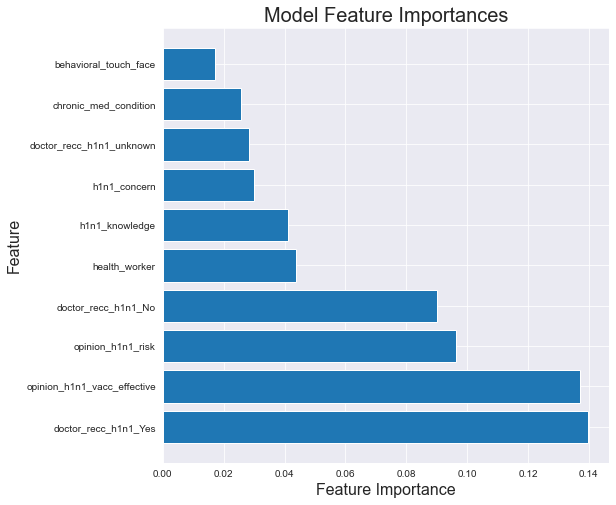

In [40]:
# Plot top 10 most important features
plot_feature_importance(forest_3)

Unsurprisingly, the most important factors are a person's opinion on the vaccine's effectiveness and their risk for getting the virus along with their doctor's recommendation.

## XG Boost

The last model we will be creating is an XG Boost model, one of the top gradient boosting algorithms.

In [41]:
# Create an XG Boost Model
boost = XGBClassifier(random_state=42)
boost.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
print('XG Boost Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           boost.predict(X_train_resampled)))
print('XG Boost Model Test Scores: \n',
     classification_report(y_test, boost.predict(X_test_final)))

XG Boost Model Training Scores: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     14615
           1       0.97      0.91      0.94     14615

    accuracy                           0.94     29230
   macro avg       0.94      0.94      0.94     29230
weighted avg       0.94      0.94      0.94     29230

XG Boost Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4898
           1       0.64      0.46      0.53      1309

    accuracy                           0.83      6207
   macro avg       0.75      0.69      0.71      6207
weighted avg       0.82      0.83      0.82      6207



Without any tuning, the training scores are performing better than the test scores.

In [49]:
# Create a parameter grid and grid search for tuning the model
boost_param_grid = {'learning_rate' : [.1, .2, .3],
                   'max_depth' : [4, 5, 6],
                   'min_child_weight' : [.5, .7, 1],
                   'n_estimators' : [100, 150, 200]}

gs_boost = GridSearchCV(boost, boost_param_grid, cv=3)
gs_boost.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [50]:
# Find the best parameters
gs_boost.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 0.7,
 'n_estimators': 100}

In [43]:
# Create a second model with the best parameters
boost_2 = XGBClassifier(random_state=42, 
                            learning_rate=.1, 
                            max_depth = 4, 
                            min_child_weight = .7, 
                            n_estimators = 100)
boost_2.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=0.7, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
print('XG Boost Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           boost.predict(X_train_resampled)))
print('XG Boost Model Test Scores: \n',
     classification_report(y_test, boost.predict(X_test_final)))
print('Second XG Boost Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           boost_2.predict(X_train_resampled)))
print('Second XG Boost Model Test Scores: \n',
     classification_report(y_test, boost_2.predict(X_test_final)))

XG Boost Model Training Scores: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     14615
           1       0.97      0.91      0.94     14615

    accuracy                           0.94     29230
   macro avg       0.94      0.94      0.94     29230
weighted avg       0.94      0.94      0.94     29230

XG Boost Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4898
           1       0.64      0.46      0.53      1309

    accuracy                           0.83      6207
   macro avg       0.75      0.69      0.71      6207
weighted avg       0.82      0.83      0.82      6207

Second XG Boost Model Training Scores: 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     14615
           1       0.93      0.86      0.90     14615

    accuracy                           0.90     29230
   macro avg       0.90

Tuning this model definitely helped us to decrease overfitting to the training data.

### Feature Importance

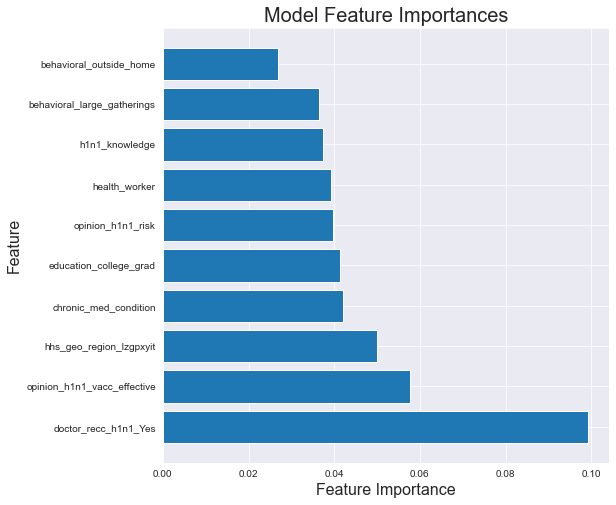

In [45]:
# Check the top ten most important features according to our XG Boost model
plot_feature_importance(boost_2)

Many of these top features are the same as the top ten features from our Random Forests Model.

# Comparing Model Scores

We will look at only our best Decision Tree, Random Forest, and XG Boost when comparing models.  It is important to note that there is still a class imbalance in our test dataset.  This will cause our precision, recall, and f1-score to be lower for the smaller class (1).  This does not mean that our model is not performing well, only that it does not have enough data.

In [46]:
print('Decision Tree Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           clf_2.predict(X_train_resampled)))
print('Decision Tree Model Test Scores: \n',
     classification_report(y_test, clf_2.predict(X_test_final)))

Decision Tree Model Training Scores: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87     14615
           1       0.90      0.83      0.86     14615

    accuracy                           0.87     29230
   macro avg       0.87      0.87      0.87     29230
weighted avg       0.87      0.87      0.87     29230

Decision Tree Model Test Scores: 
               precision    recall  f1-score   support

           0       0.88      0.88      0.88      4898
           1       0.55      0.55      0.55      1309

    accuracy                           0.81      6207
   macro avg       0.72      0.71      0.72      6207
weighted avg       0.81      0.81      0.81      6207



This model is not overfit.  The scores for the training data and the test data are very similar.  However, we only have an accuracy score of 81% for the test data.

In [47]:
print('Third Random Forests Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           forest_3.predict(X_train_resampled)))
print('Third Random Forests Model Test Scores: \n',
     classification_report(y_test, forest_3.predict(X_test_final)))

Third Random Forests Model Training Scores: 
               precision    recall  f1-score   support

           0       0.91      0.94      0.92     14615
           1       0.94      0.90      0.92     14615

    accuracy                           0.92     29230
   macro avg       0.92      0.92      0.92     29230
weighted avg       0.92      0.92      0.92     29230

Third Random Forests Model Test Scores: 
               precision    recall  f1-score   support

           0       0.88      0.91      0.90      4898
           1       0.62      0.53      0.57      1309

    accuracy                           0.83      6207
   macro avg       0.75      0.72      0.73      6207
weighted avg       0.82      0.83      0.83      6207



Even though we adjusted our parameters to combat overfitting, this model is still scoring much better for the training set than for the test set.  However, this model does give us an accuracy score of 83% for the test set.

In [48]:
print('Second XG Boost Model Training Scores: \n',
     classification_report(y_train_resampled, 
                           boost_2.predict(X_train_resampled)))
print('Second XG Boost Model Test Scores: \n',
     classification_report(y_test, boost_2.predict(X_test_final)))

Second XG Boost Model Training Scores: 
               precision    recall  f1-score   support

           0       0.87      0.94      0.90     14615
           1       0.93      0.86      0.90     14615

    accuracy                           0.90     29230
   macro avg       0.90      0.90      0.90     29230
weighted avg       0.90      0.90      0.90     29230

Second XG Boost Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4898
           1       0.65      0.49      0.56      1309

    accuracy                           0.84      6207
   macro avg       0.76      0.71      0.73      6207
weighted avg       0.83      0.84      0.83      6207



The XG Boost model is arguably our best model.  It is not overfit to the training data, and also gives us an accuracy score of 84% for our test data.

# Vaccination by Group

I would like to look into the vaccination rates of some of our most important features: Doctor Recommendation, Education Level, and H1N1 Knowledge.

We will be using the data from our our original DataFrame in order to capture the most data.

In [305]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

## Doctor Recommendations

In [8]:
# Change 0 and 1 to No and Yes, respectively
data_df['doctor_recc_h1n1'].replace(to_replace=0.0, value='No', inplace=True)
data_df['doctor_recc_h1n1'].replace(to_replace=1.0, value='Yes', inplace=True)
data_df['doctor_recc_h1n1'].dropna(inplace=True)

In [10]:
# Create a dataframe of vaccinations by doctor recommendation
counts = data_df.groupby('doctor_recc_h1n1')['h1n1_vaccine'].value_counts().unstack()
counts

h1n1_vaccine,0,1
doctor_recc_h1n1,,
No,16529,2610
Yes,2529,2879


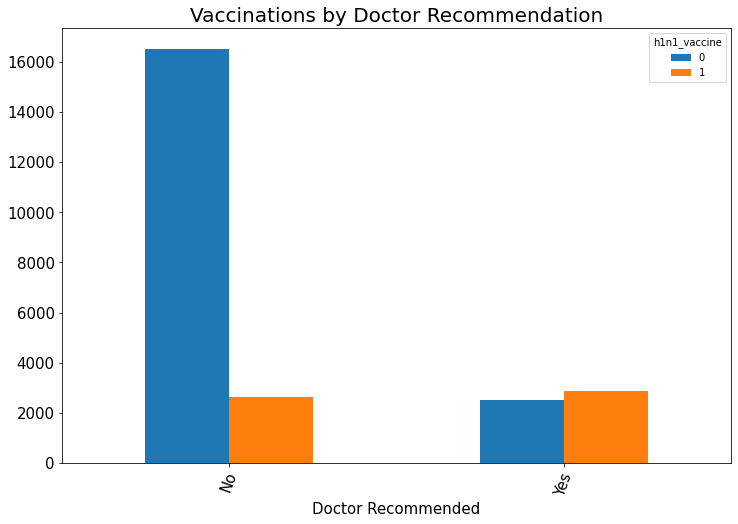

In [11]:
# Plot the vaccinations counts by doctor recommendation
fig, ax = plt.subplots(figsize=(12,8))
counts.plot(kind='bar', ax=ax, fontsize=15)
ax.set_xlabel('Doctor Recommended', fontsize=15)
plt.title('Vaccinations by Doctor Recommendation', fontsize=20)
plt.xticks(rotation=70);

In [12]:
# Create new columns for percentages
recc_counts = counts
recc_counts['total'] = recc_counts[0]+recc_counts[1]
recc_counts['percentage_yes'] = recc_counts[1]/recc_counts['total']
recc_counts['percentage_no'] = recc_counts[0]/recc_counts['total']
recc_counts

h1n1_vaccine,0,1,total,percentage_yes,percentage_no
doctor_recc_h1n1,,,,,
No,16529,2610,19139,0.136371,0.863629
Yes,2529,2879,5408,0.532359,0.467641


In [13]:
# Reset the index to prepare for plotting
recc_counts.reset_index(inplace=True)
recc_counts

h1n1_vaccine,doctor_recc_h1n1,0,1,total,percentage_yes,percentage_no
0,No,16529,2610,19139,0.136371,0.863629
1,Yes,2529,2879,5408,0.532359,0.467641


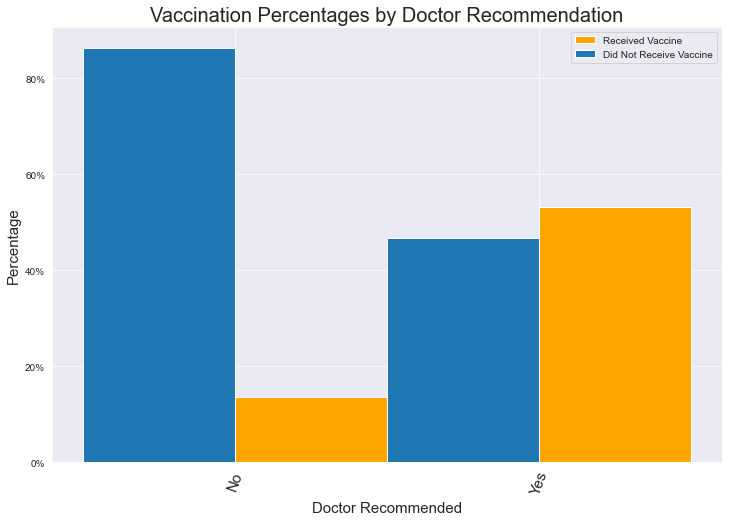

In [27]:
# Plot the percentages of vaccinations by doctor recommendation
fig, ax = plt.subplots(figsize=(12,8))
sns.set_style('darkgrid')
plt.bar(recc_counts['doctor_recc_h1n1'], 
        recc_counts['percentage_yes']*100, 
        width=.5, 
        align='edge', 
        color='orange', 
        label='Received Vaccine')
plt.bar(recc_counts['doctor_recc_h1n1'], 
        recc_counts['percentage_no']*100, 
        width=-.5, 
        align='edge', 
        label='Did Not Receive Vaccine')
ax.set_xlabel('Doctor Recommended', fontsize=15)
plt.title('Vaccination Percentages by Doctor Recommendation', fontsize=20)
ax.set_ylabel('Percentage', fontsize=15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend()
plt.xticks(fontsize=15, rotation=70);

This plot shows the huge difference that a doctor's recommendation makes.  People are much more likely to get vaccinated if it is recommended by their doctor.

## Education Level

In [17]:
# Create a dataframe for vaccinations by education
ed_counts = data_df.groupby('education')['h1n1_vaccine'].value_counts().unstack()
ed_counts

h1n1_vaccine,0,1
education,,
12 Years,4726,1071
< 12 Years,1968,395
College Graduate,7614,2483
Some College,5579,1464


In [18]:
# Create new columns for percentages
ed_counts['total'] = ed_counts[0]+ed_counts[1]
ed_counts['percentage_yes'] = ed_counts[1]/ed_counts['total']
ed_counts['percentage_no'] = ed_counts[0]/ed_counts['total']
ed_counts

h1n1_vaccine,0,1,total,percentage_yes,percentage_no
education,,,,,
12 Years,4726,1071,5797,0.184751,0.815249
< 12 Years,1968,395,2363,0.167160,0.832840
College Graduate,7614,2483,10097,0.245915,0.754085
Some College,5579,1464,7043,0.207866,0.792134


In [19]:
# Sort the values by percentage of those who did receive the vaccine
ed_counts = ed_counts.sort_values('percentage_yes')
ed_counts

h1n1_vaccine,0,1,total,percentage_yes,percentage_no
education,,,,,
< 12 Years,1968,395,2363,0.167160,0.832840
12 Years,4726,1071,5797,0.184751,0.815249
Some College,5579,1464,7043,0.207866,0.792134
College Graduate,7614,2483,10097,0.245915,0.754085


In [20]:
# Reset the index 
ed_counts.reset_index(inplace=True)
ed_counts

h1n1_vaccine,education,0,1,total,percentage_yes,percentage_no
0,< 12 Years,1968,395,2363,0.167160,0.832840
1,12 Years,4726,1071,5797,0.184751,0.815249
2,Some College,5579,1464,7043,0.207866,0.792134
3,College Graduate,7614,2483,10097,0.245915,0.754085


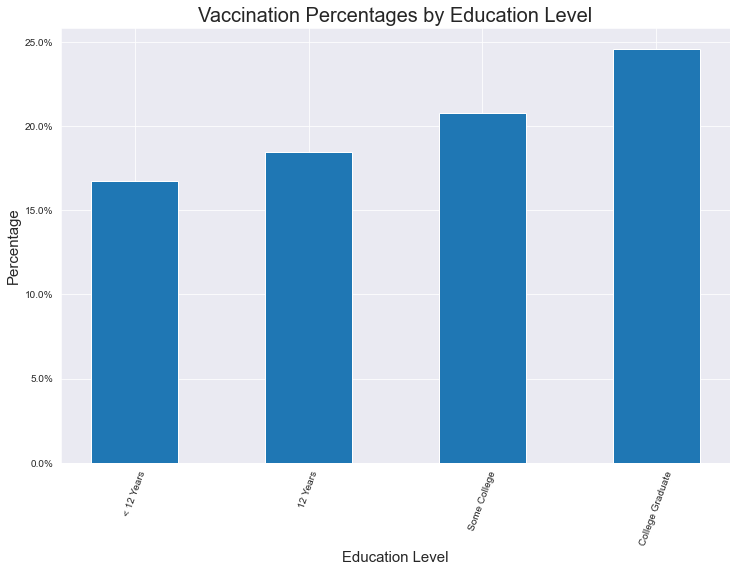

In [28]:
# Plot the vaccination percentages by education
fig, ax = plt.subplots(figsize=(12,8))
sns.set_style('darkgrid')
plt.bar(ed_counts['education'], 
        ed_counts['percentage_yes']*100, 
        width=.5, 
        label='Received Vaccine')
ax.set_xlabel('Education Level', fontsize=15)
plt.title('Vaccination Percentages by Education Level', fontsize=20)
ax.set_ylabel('Percentage', fontsize=15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=70);

This plot illustrates that more people with a higher level education get vaccinated than people whose education is at a lower level.

## H1N1 Knowledge

In [22]:
# Create a dataframe for vaccinations by h1n1 knowledge
h1n1_counts = data_df.groupby('h1n1_knowledge')['h1n1_vaccine'].value_counts().unstack()
h1n1_counts

h1n1_vaccine,0,1
h1n1_knowledge,,
0.0,2145,361
1.0,11945,2653
2.0,6849,2638


In [23]:
# Create columns for percentages
h1n1_counts['total'] = h1n1_counts[0]+h1n1_counts[1]
h1n1_counts['percentage_yes'] = h1n1_counts[1]/h1n1_counts['total']
h1n1_counts['percentage_no'] = h1n1_counts[0]/h1n1_counts['total']
h1n1_counts

h1n1_vaccine,0,1,total,percentage_yes,percentage_no
h1n1_knowledge,,,,,
0.0,2145,361,2506,0.144054,0.855946
1.0,11945,2653,14598,0.181737,0.818263
2.0,6849,2638,9487,0.278065,0.721935


In [24]:
# Reset the index for plotting
h1n1_counts.reset_index(inplace=True)
h1n1_counts

h1n1_vaccine,h1n1_knowledge,0,1,total,percentage_yes,percentage_no
0,0.0,2145,361,2506,0.144054,0.855946
1,1.0,11945,2653,14598,0.181737,0.818263
2,2.0,6849,2638,9487,0.278065,0.721935


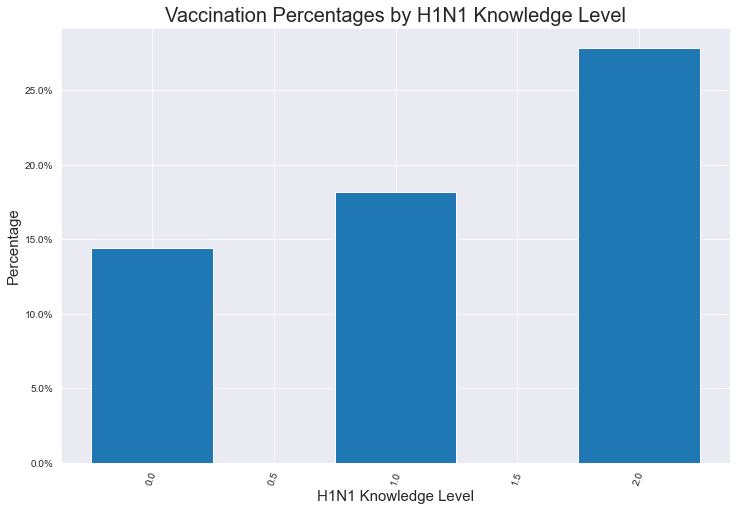

In [29]:
# Plot the vaccination percentages by h1n1 knowledge
fig, ax = plt.subplots(figsize=(12,8))
sns.set_style('darkgrid')
plt.bar(h1n1_counts['h1n1_knowledge'], 
        h1n1_counts['percentage_yes']*100, 
        width=.5, 
        label='Received Vaccine')
ax.set_xlabel('H1N1 Knowledge Level', fontsize=15)
plt.title('Vaccination Percentages by H1N1 Knowledge Level', fontsize=20)
ax.set_ylabel('Percentage', fontsize=15)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(rotation=70);

As expected, those that have more knowledge about the H1N1 virus are more likely to be vaccinated than those with little or no knowledge.

# Conclusion and Recommendations

If the company has access to all of this information for it's population groups, then I would recommend using the XG Boost model in order to predict the number of vaccines that they would need to distribute.  This model performed the best without being overfit to the training data.

However, it is unlikely that the company will be able to gather such a vast amount of information from every population. In this case, I recommend:

* Distributing more vaccines to populations with a higher percentage of college graduates.
* Working with clinics and doctors to understand the amount of patients they are recommending the vaccine to.